# Assignment — Community Detection part 2

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from zlib import adler32

### Task 1. Louvain method (1.5 points)

Louvain method is one of the mostcited works in the community detection literature. It is a simple method to extract the community structure of large networks. This method is a heuristic method that is based on modularity optimization. Let us consider this method on a fractal graph that can represent some biological structure.

In [2]:
def fractal_graph(n, k, G):
    if k == 0:
        return G
    for node in list(G.nodes):
        newG = nx.complete_graph(n)
        newG = nx.relabel_nodes(newG, {node:max(G.nodes)+node+1 for node in newG.nodes})
        G = nx.union(G, newG)
        for edge in G.edges(node):
            G.add_edge(list(G.nodes)[-1], edge[1])
        G.remove_node(node)
    return fractal_graph(n, k-1, G)

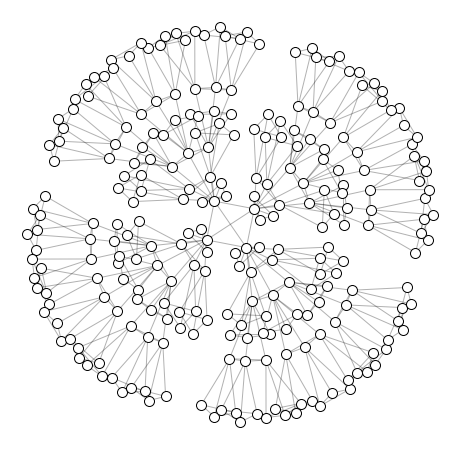

In [3]:
n = 4
fractalG = fractal_graph(n, 3, nx.complete_graph(n))

plt.figure(figsize=(8, 8))
frac_pos = nx.kamada_kawai_layout(fractalG)
nx.draw_networkx_nodes(fractalG, frac_pos, node_color='white', 
                       edgecolors='black', node_size=100)
nx.draw_networkx_edges(fractalG, frac_pos, alpha=0.3)
plt.axis('off')
plt.show()

Louvain method is a greedy algorithm of modularity gain that is described as: 

Phase 1
1. Put each node in its own community
2. For every node, calculate modularity gain by removing it from its community and placing it in neighbor's community
3. Put a node in the community with maximal modularity gain
4. Repeat 2, 3 until modularity stops increasing

Phase 2
1. Merge communities into ”super nodes”
2. Convert edges inside community into self loop, edges between communities into parallel edges

Repeat phases 1, 2 until modularity stops increasing.

In [4]:
def louvain_method(G):
    
    # Phase 1
    communities = unfolded_communities(G)
    labels = []
    for node in G.nodes:
        for i, c in enumerate(communities):
            if node in c:
                labels.append(i)
    
    # Phase 2
    nextG = nx.empty_graph(len(communities), nx.MultiGraph)
    for e in G.edges:
        for i in range(len(communities)):
            for j in range(len(communities)):
                if e[0] in communities[i] and e[1] in communities[j]:
                    nextG.add_edge(i, j)
                    
    # Shuffle colors for better visualization
    palette = np.unique(labels)
    key = np.random.permutation(palette)
    labels = key[np.digitize(labels, palette, right=True)]
    
    return communities, labels, nextG

Write a function `unfolded_communities` that takes a graph, performs Phase 1 and returns np.array of communities with nodes. For example, if there are two communitites: the first is [1,2] and the second is [3,4,5] then the output will be [[1,2],[3,4,5]].

In [ ]:
def unfolded_communities(G):
    # Proposed template:
    communities = [[n] for n in G.nodes] # initial partition
    prev_max_modularity = -np.inf
    max_modularity = nx.algorithms.community.modularity(G, communities)
    while max_modularity > prev_max_modularity:
        prev_max_modularity = max_modularity
        for node in np.random.permutation(G.nodes):
            '''
            1) Remove the node from the initial community.
            2) Iterate all neighboring communities and move the node
               into a community with the maximum modularity gain. If 
               there is no modularity gain, return the node into the 
               initial community.
            '''
            # YOUR CODE HERE
            raise NotImplementedError()
    return [c for c in communities if len(c)]

In [ ]:
n = 4
fractalG = fractal_graph(n, 2, nx.complete_graph(n))
iterG = fractalG.copy()
communities, labels, nextG = louvain_method(iterG)

assert len(set(labels)) == 16
assert len(set(labels[52:56])) == 1
assert len(set(labels[52:57])) == 2
assert nextG.number_of_nodes() == 16
assert round(np.linalg.det(nx.to_numpy_array(nextG)) * 1e-10, 4) == 136.5257

Let us see unfolding iterations. For every iteration we draw a graph where node color corresponds to the unfolded community.

In [ ]:
n = 4
fractalG = fractal_graph(n, 3, nx.complete_graph(n))
iterG = fractalG

plt.figure(figsize=(7, 7*3))
for i in range(3):
    plt.subplot(3, 1, i+1)
    communities, labels, nextG = louvain_method(iterG)
    iter_pos = nx.kamada_kawai_layout(iterG)
    nodes = nx.draw_networkx_nodes(
        iterG,
        iter_pos,
        cmap=plt.cm.rainbow,
        node_color=labels,
        edgecolors='black',
        node_size=100)
    nx.draw_networkx_edges(
        iterG,
        iter_pos,
        node_size=100)
    plt.axis('off')
    plt.title(
        '{} nodes, {} communities \nModularity {:.2f}'.format(
            len(iterG), len(communities), nx.community.modularity(iterG, communities)))
    iterG = nextG

### Task 2. Ego-Splitting (1.5 points)

Ego-Splitting is a framework for detecting clusters in complex networks which leverage the local structures known as ego-nets (i.e. the subgraph induced by the neighborhood of each node) to detect overlapping clusters. Ego-splittng is a highly scalable and flexible framework, with provable theoretical guarantees, that reduces the complex overlapping clustering problem to a simpler and more amenable non-overlapping (partitioning) problem.

Let us consider the algorithm on this small graph.

In [ ]:
adjlist = [
    'a b c e h g i',
    'f b c e h g i',
    'b e c',
    'g i h',
    'e c d',
    'c d',
    'i h j',
    'h j',
    'j d k',
    'd k'
]
G = nx.parse_adjlist(adjlist)
plt.figure(figsize=(5, 5))
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), 
                 node_size=400, node_color='lightgray')
plt.axis('off');

The ego-splitting algorithm processes a graph $G = (V, E)$ and outputs a set of clusters $S$ as follows:
1. For each node $u$ we use the local clustering algorithm to partition the ego-net of $u$.
2. Create a set $V'$ of personas. Each node $u$ in $V$ will correspond to $t_u$ personas in $V'$.
3. Add edges between personas.
4. Apply the global clustering algorithm.

![](https://raw.githubusercontent.com/netspractice/network-science/main/assignment_communities_2/ego_splitting.png)

In [ ]:
def ego_splitting(graph):
    ego_nets = generate_ego_nets(graph)
    persona_graph = generate_persona_graph(ego_nets)
    return persona_clustering(personaG)

Write a function `generate_ego_nets` that takes a graph and returns a dictionary where keys are nodes and values are their ego-nets:

`{'a': ego-net of the node a, 'b': ego-net of the node b, ...}`

Ego-net *does not* include the ego-node.

*Hint: use `nx.ego_graph`*

In [ ]:
def generate_ego_nets(graph):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
ego_nets = generate_ego_nets(G)
assert set(ego_nets.keys()) == {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'}
assert set(ego_nets['d'].nodes) == {'c', 'e', 'j', 'k'}
assert set(ego_nets['f'].nodes) == {'b', 'c', 'e', 'g', 'h', 'i'}

In [ ]:
nx.draw_networkx(ego_nets['f'], pos=nx.kamada_kawai_layout(G), 
        node_color='lightgray', node_size=400)
plt.title('Ego-net of the node f')
plt.axis('off')
plt.show()

Next, we need to split each ego-net using any clustering method. Let it be the simple connected component detection method. 

In [ ]:
def ego_clustering(graph):
    return [cc for cc in nx.connected_components(graph)]

Write a function `generate_persona_graph` that takes an ego-net dictionary and returns a persona graph:
1. Apply ego clustering for each ego-net.
2. Add a replica of the ego-node into each cluster and link it to each member. If there is more than one cluster then the replica name is the node name + cluster index. For example, if the ego-net `a` has clusters `[b, c]` and `[d]` then we add edges `[a0, b]`, `[a0, c]` and `[a1, d]`. Otherwise, the replica name is the node name.
3. Union all ego-nets into persona graph. Remove all nodes that has replicas. For example, if the graph has nodes `a`, `a0`, `a1`, then remove the node `a`.

In [ ]:
def generate_persona_graph(ego_nets):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
ego_nets = generate_ego_nets(G)
personaG = generate_persona_graph(ego_nets)
assert set(personaG.nodes) == {'i', 'f0', 'k', 'c', 'd0', 'a0', 'g', 'j0', 'e', 'h', 'd1', 'a1', 'j1', 'f1', 'b'}
assert {i[0] for i in personaG.neighbors('k')} == {'d', 'j'}
assert {i[0] for i in personaG.neighbors('g')} == {'a', 'f', 'h', 'i'}

Finally, we need to apply any clustering algorithm for the persona graph. Let it again be the simple connected component detection algorithm. Also, here we remove the cluster indexes from node names.

In [ ]:
def persona_clustering(graph):
    communities = [cc for cc in nx.connected_components(graph)]
    for c in communities:
        for node in c:
            c.remove(node)
            c.add(node[0])
    return communities

In [ ]:
plt.figure(figsize=(15, 5))
pos = nx.kamada_kawai_layout(G)
c_colors = ['tab:orange', 'tab:blue', 'tab:green']
for i, c in enumerate(ego_splitting(G)):
    plt.subplot(1, 3, i+1)
    color = []
    for node in G.nodes:
        color.append(c_colors[i] if node in c else 'white')
    nx.draw_networkx(G, pos=pos, node_color=color, 
                     edgecolors='black', node_size=400)
    plt.axis('off')
    plt.title('Colored nodes are in the community {}'.format(i+1))

### Task 3. Label propogation (7 points)

The label propogation method is based on the simple idea: every node is initialized with a unique label and at every step each node adopts the label that most of its neighbors currently have.

Write a function `update_labels` that takes a graph, np.array with labels in order `graph.nodes` and returns new labels. Label of the node is the random label occurring with the highest frequency among neighbors at the previous step. The order in which all the n nodes in the network are updated at each iteration is chosen randomly.

In [26]:
def get_new_label_from_observed(observed):
    max_observation = -np.inf
    max_observation_key = None
    for key in observed:
        if observed[key] > max_observation:
            max_observation = observed[key]
            max_observation_key = key
    return max_observation_key

def update_labels(graph, labels):
    new_labels = []
    
    for node in graph.nodes():
        observed = dict()
        for neighbour in G.neighbors(node):
            idx = list(graph.nodes()).index(neighbour)
            if labels[idx] not in observed:
                observed[labels[idx]] = 0
            else:
                observed[labels[idx]] += 1
        new_labels.append(get_new_label_from_observed(observed))
    return np.array(new_labels)

In [27]:
G = nx.karate_club_graph()
labels = np.array(list(G.nodes)) # initial partition
new_labels = update_labels(G, labels)
assert new_labels.shape == (34, )
assert len(set(new_labels)) < len(set(labels))
G = nx.star_graph(4)
labels = np.array(list(G.nodes)) # initial partition
for _ in range(5):
    labels = update_labels(G, labels)
new_labels = update_labels(G, labels)
assert len(set(new_labels - labels)) == 2
assert np.sum(list(set(new_labels - labels))) == 0

In [28]:
def plot_propogation(G, update_method, n=50):
    pos=nx.kamada_kawai_layout(G)
    labels = np.array(list(G.nodes))
    for i in range(n):
        clear_output(wait=True)
        labels = update_method(G, labels)
        plt.figure(figsize=(6, 6))
        nx.draw_networkx_nodes(G, pos=pos, node_color=labels, cmap=plt.cm.tab10_r)
        nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
        nx.draw_networkx_labels(G, pos=pos)
        plt.axis('off')
        plt.title('Iteration {}/{}'.format(i+1, n))
        plt.show()

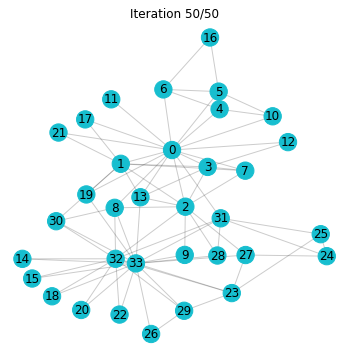

In [31]:
G = nx.karate_club_graph()
plot_propogation(G, update_labels)

The problem however is that subgraphs in the network that are bi-partite or nearly bi-partite in structure lead to oscillations of labels.  This is especially true in cases where communities take the form of a star graph.

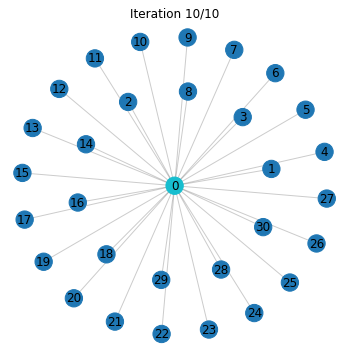

In [32]:
G = nx.star_graph(30)
plot_propogation(G, update_labels, 10)

Hence we need to use asynchronous updating where some neighbors have already been updated in the current iteration while some neighbors are not yet updated in the current iteration.

Write a function `async_update_labels` that make asynchronous label updating. The order in which all the n nodes in the network are updated at each iteration is chosen randomly.

In [ ]:
def async_update_labels(graph, labels):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
G = nx.karate_club_graph()
labels = np.array(list(G.nodes)) # initial partition
new_labels = async_update_labels(G, labels)
assert new_labels.shape == (34, )
assert len(set(new_labels)) < len(set(labels))
G = nx.star_graph(4)
labels = np.array(list(G.nodes)) # initial partition
for _ in range(5):
    labels = async_update_labels(G, labels)
new_labels = async_update_labels(G, labels)
assert np.all(new_labels - labels == 0)

In [ ]:
plot_propogation(nx.star_graph(30), async_update_labels, 10)

In [ ]:
plot_propogation(nx.karate_club_graph(), async_update_labels, 30)